# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
from keras.regularizers import l1,l2
import tensorflow as tf
import random
import math
from random import shuffle

Using TensorFlow backend.


In [2]:
keras.__version__

'2.3.1'

In [3]:
tf.__version__

'2.1.0'

# Generators

In [4]:
def image_generator(files, batch_size = 32, sz = (256, 256)):
  batch_in_files = files[:]
  while True: 
    if batch_in_files==[]:
      #print(len(files))
      batch_in_files = files[:]
      shuffle(batch_in_files)
      
    batch = batch_in_files[0:batch_size]    
    del batch_in_files[0:batch_size]
          
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
    
    for f in batch:

        #get the masks. Note that masks are png files 
        mask = Image.open(f.replace('green', 'mask'))
        mask = np.array(mask.resize(sz))
        #preprocess the mask 
        mask[mask == 4] = 0
        mask[mask >= 1] = 1
        mask = np.nan_to_num(mask)
        
        batch_y.append(mask)

        #preprocess the raw images 
        
        #Green
        g = Image.open(f)
        
        #raw = raw.resize(sz)
        g = np.array(g)
        g[g<=0] =0
        #g[g>1] = 1
        g = np.nan_to_num(g)
        
        #Red
        r = Image.open(f.replace('green', 'red'))
        r = np.array(r)
        r[r<=0]=0
        #r[r>1]=1
        r = np.nan_to_num(r)

        #Blue               
        b = Image.open(f.replace('green', 'blue'))
        b = np.array(b)
        b[b<=0]=0
        #b[b>1]=1
        b = np.nan_to_num(b)

        #nir
        nir = Image.open(f.replace('green', 'nir'))
        nir = np.array(nir)
        nir[nir<=0]=0
        #nir[nir>1]=1
        nir = np.nan_to_num(nir)
        
        #red_edge
        red_edge = Image.open(f.replace('green', 'rededge'))
        red_edge = np.array(red_edge)
        red_edge[red_edge<=0] =0
        #red_edge[red_edge>1]=1
        red_edge = np.nan_to_num(red_edge)     

        #dsm
        dsm = Image.open(f.replace('green', 'dsm'))
        dsm = np.array(dsm)
        #dsm[dsm>1]=1
        dsm = np.nan_to_num(dsm)
        
        #ExGR
        exgr = 3*g-2.3*r-b

#         raw data                                 
        raw = np.dstack((r,g,b,nir,red_edge,dsm,exgr))
#         raw = np.dstack((r,g,b,dsm))
        batch_x.append(raw)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3)

    yield (batch_x, batch_y)      
    

In [5]:
path = 'Path/to/train-data'

batch_size = 32
all_files = []
for root, sub, files in os.walk(path):
  for filename in files:
    if 'green' in filename:
      all_files.append(os.path.join(root,filename))

shuffle(all_files)
split = int(0.7 * len(all_files))
split_train = int(0.7 * split)

#split into training and testing
train_files = all_files[0:split_train]
test_files  = all_files[split_train:split]
test_stat = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

In [24]:
print("all image number =", len(all_files),
     "train image number =", len(train_files),
     "validation image number =", len(test_files),
     "test imgae number =", len(test_stat))

all image number = 9845 train image number = 4823 validation image number = 2068 test imgae number = 2954


In [7]:
x, y= next(test_generator)

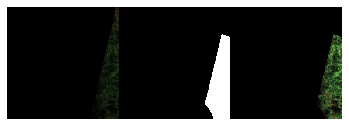

In [9]:
plt.axis('off')
s_img = x[2]
s_img = s_img[:,:,0:3]
msk = y[2].squeeze()
msk = np.stack((msk,)*3, axis=-1)
plt.imshow( np.concatenate([s_img, msk, s_img*msk*3], axis = 1))

# IoU metric

The intersection over union (IoU) metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $x_{true}, x_{pred}$ we evaluate 

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [7]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

# Model

In [12]:
def unet(sz = (256, 256, 4)):
    
  x = Input(sz)
  inputs = x
  
  #down sampling 
  f = 8
  layers = []
  
  x = BatchNormalization(axis=3,name='bn1')(x)
  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same',kernel_initializer = 'he_normal',kernel_regularizer=l2(0.0001),bias_regularizer=l2(0.0001)) (x)
    x = Conv2D(f, 3, activation='relu', padding='same',kernel_initializer = 'he_normal',kernel_regularizer=l2(0.0001),bias_regularizer=l2(0.0001)) (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64 
  
  #bottleneck 
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same', kernel_initializer = 'he_normal',kernel_regularizer=l2(0.0001),bias_regularizer=l2(0.0001)) (x)
  x = Conv2D(f, 3, activation='relu', padding='same', kernel_initializer = 'he_normal',kernel_regularizer=l2(0.0001),bias_regularizer=l2(0.0001)) (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  
  #upsampling 
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, activation='relu', padding='same', kernel_initializer = 'he_normal',kernel_regularizer=l2(0.0001),bias_regularizer=l2(0.0001)) (x)
    x = Conv2D(f, 3, activation='relu', padding='same', kernel_initializer = 'he_normal',kernel_regularizer=l2(0.0001),bias_regularizer=l2(0.0001)) (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  
  #classification 
  x = Conv2D(f, 3, activation='relu', padding='same', kernel_initializer = 'he_normal',kernel_regularizer=l2(0.0001),bias_regularizer=l2(0.0001)) (x)
  x = Conv2D(f, 3, activation='relu', padding='same', kernel_initializer = 'he_normal',kernel_regularizer=l2(0.0001),bias_regularizer=l2(0.0001)) (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)
  
  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy', mean_iou])
  
  return model

In [13]:
model = unet()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


# Callbacks

Simple functions to save the model at each epoch and show some predictions 

In [14]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks
      
# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.logs = []
        self.iou = []
        self.val_iou = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
        self.iou.append(logs.get('mean_iou'))
        self.val_iou.append(logs.get('val_mean_iou'))
        
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_acc=',logs.get('acc'),'val_mean_acc=',logs.get('val_acc'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        #choose a random test image and preprocess
        tf = np.random.choice(test_files)

        #Green
        g = Image.open(tf)
        g = np.array(g)
        g[g<=0] =0
        g = np.nan_to_num(g)
        
        #Red
        r = Image.open(tf.replace('green', 'red'))
        r = np.array(r)
        r[r<=0]=0
        r = np.nan_to_num(r)

        #Blue               
        b = Image.open(tf.replace('green', 'blue'))
        b = np.array(b)
        b[b<=0]=0
        b = np.nan_to_num(b)

        #nir
        nir = Image.open(tf.replace('green', 'nir'))
        nir = np.array(nir)
        nir[nir<=0]=0
        #nir[nir>1]=1
        nir = np.nan_to_num(nir)
        
        #red_edge
        red_edge = Image.open(tf.replace('green', 'rededge'))
        red_edge = np.array(red_edge)
        red_edge[red_edge<=0] =0
        #red_edge[red_edge>1]=1
        red_edge = np.nan_to_num(red_edge)     

        #dsm
        dsm = Image.open(tf.replace('green', 'dsm'))
        dsm = np.array(dsm)
        dsm = np.nan_to_num(dsm)
        
        #ExGR
        exgr = 3*g-2.3*r-b

        raw = np.dstack((r,g,b,nir,red_edge,dsm,exgr))
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        
        #mask post-processing 
        msk  = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        #for analysdata
        #predict.append(msk)
        
        #for 5 bands
        msk[msk >=0.7] = 1 
        msk[msk <0.7] = 0 
        #unique, counts = np.unique(msk, return_counts=True)
        
        # print(path,np.mean(msk))
        
        ans = Image.open(tf.replace('green', 'mask'))
        ans = np.array(ans)
        ans[ans == 4] =0
        ans[ans >= 1] =1
        ans = np.stack((ans,)*3, axis=-1)
        
        #show the mask and the segmented image         
        show = raw[:,:,0:3]*5
        combined = np.concatenate([show, msk, show*msk, ans,show* ans], axis = 1)
        
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

# Training 6 Channels

In [ ]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size

history = model.fit_generator(train_generator, 
                    epochs = 100, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 0)

#Save Model

In [14]:
model.save('C:/Users/HGR-Rage2/Desktop/MLforthesis/multiclass-newtrain/model/binary-class_1_2exgr.h5')

In [15]:
model.save_weights('C:/Users/HGR-Rage2/Desktop/MLforthesis/multiclass-newtrain/model/binary-class_1_2exgr_weight.h5')

# Visualize Model Training

A plot of accuracy on the training and validation datasets over training epochs.


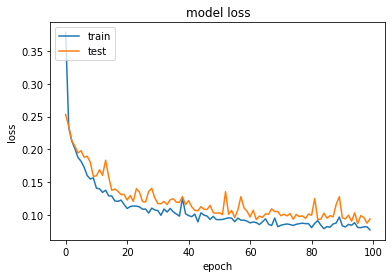

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

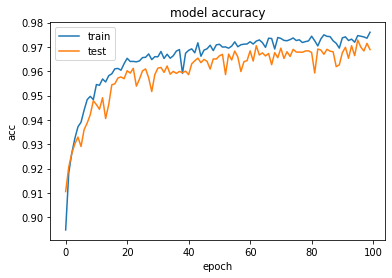

In [17]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

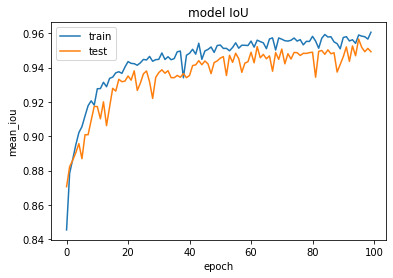

In [18]:
plt.plot(history.history['mean_iou'])
plt.plot(history.history['val_mean_iou'])
plt.title('model IoU')
plt.ylabel('mean_iou')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

A plot of loss on the training and validation datasets over training epochs.

# Testing

In [8]:
# model.load_weights('C:/Users/HGR-Rage2/Desktop/MLforthesis/multiclass-newtrain/model/binary_class_weights.h5')

In [ ]:
from keras.models import load_model
model = load_model('C:/Users/HGR-Rage2/Desktop/MLforthesis/multiclass-newtrain/model/binary-class_5bandaddExGR.h5', compile = False)


In [28]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy', mean_iou])

In [29]:
path_tastdata = "C:/Users/HGR-Rage2/Desktop/MLforthesis/multiclass-newtrain/test-FalseNeg/testdata"
test_specific = []
for root, sub, files in os.walk(path_tastdata):
  for filename in files:
    if 'green' in filename:
        test_specific.append(os.path.join(root, filename))

In [ ]:
loss_value_all = []
metrics_values_all = []
iou_values_all = []
false_Pos_all = []
false_neg_all = []
iou = []
for f in test_specific:
    testG = Image.open(f)
    testG = np.array(testG)
    testG[testG<=0]=0

    testR = Image.open(f.replace('green', 'red'))
    testR = np.array(testR)
    testR[testR<=0]=0

    testB = Image.open(f.replace('green', 'blue'))
    testB = np.array(testB)
    testB[testB<=0]=0

    testNir = Image.open(f.replace('green', 'nir'))
    testNir = np.array(testNir)
    testNir[testNir<=0]=0

    testRedE = Image.open(f.replace('green', 'rededge'))
    testRedE = np.array(testRedE)
    testRedE[testRedE<=0]=0

    testMsk = Image.open(f.replace('green', 'mask'))
    testMsk = np.array(testMsk)
    testMsk[testMsk == 4] = 0
    testMsk[testMsk >= 1] = 1

    testDSM = Image.open(f.replace('green', 'dsm'))
    testDSM = np.array(testDSM)
    
    exg = 2*testG-testR-testB
    exr = 1.3*testR-testG
    #ExGR
    exgr = exg-exr


    mskfor_evalu = np.stack((testMsk,)*1, axis=-1)

    raw = np.dstack((testR, testG, testB, testNir, testRedE, testDSM, exgr))
    loss_value,metrics_values,iou_values = model.evaluate(np.expand_dims(raw,0),np.expand_dims(mskfor_evalu,0))
    
    pred = model.predict(np.expand_dims(raw, 0))
    msk  = pred.squeeze()
    msk[msk >=0.7] = 1 
    msk[msk <0.7] = 0 

    #Evaluate IoU
    #iou.append(mean_iou(testMsk, msk))
    #Evaluate False Positives Rate
    FP = np.sum(np.logical_and(msk == 1, testMsk == 0))
    TN = np.sum(np.logical_and(msk == 0, testMsk == 0))
    FN = np.sum(np.logical_and(msk == 0, testMsk == 1))
    #print('False Positives: ',FP)
    false_Pos_all.append(FP)
    false_neg_all.append(FN)


    msk = np.stack((msk,)*3, axis=-1)

    #score = model.evaluate(raw,testMsk)
    print(loss_value,metrics_values,iou_values)
    loss_value_all.append(loss_value)
    metrics_values_all.append(metrics_values)
    iou_values_all.append(iou_values)

    #show = raw[:,:,0:3]*5
    testMsk = np.stack((testMsk,)*3, axis=-1)
    combined = np.concatenate([raw[:,:,0:3]*[5,5,5],msk,testMsk], axis = 1)

    plt.axis('off')
    plt.imshow(combined)
    plt.show()



loss_val_mean =  0.10617144141217758  loss_val_max =  1.459302544593811  loss_val_min =  0.011924106627702713  loss_val_sd =  0.20899407390369137


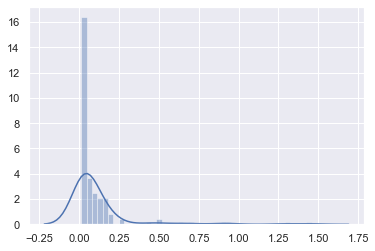

In [32]:
import seaborn as sns
import statistics
sns.set(color_codes=True)
sns.distplot(loss_value_all);

loss_value_all = np.array(loss_value_all)
print('loss_val_mean = ',loss_value_all.mean(),' loss_val_max = ',loss_value_all.max(),' loss_val_min = ',loss_value_all.min(),' loss_val_sd = ',np.std(loss_value_all))
#plt.hist(loss_value_all)

acc_val_mean =  0.9707631078259699  acc_val_max =  1.0  acc_val_min =  0.5479583740234375  acc_val_sd =  0.06397666160899214


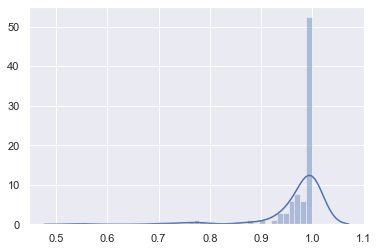

In [33]:
sns.set(color_codes=True)   
sns.distplot(metrics_values_all);

metrics_values_all = np.array(metrics_values_all)
print('acc_val_mean = ',metrics_values_all.mean(),' acc_val_max = ',metrics_values_all.max(),' acc_val_min = ',metrics_values_all.min(),' acc_val_sd = ',np.std(metrics_values_all))

IoU_maen =  0.9071045556972767  IoU_max =  1.0  IoU_min =  0.0  IoU_sd =  0.19971556980522714


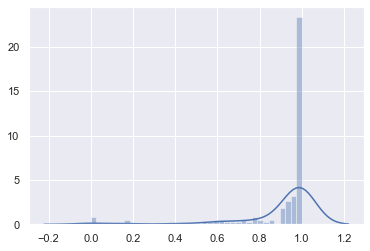

In [34]:
sns.set(color_codes=True)   
sns.distplot(iou_values_all);

iou_values_all = np.array(iou_values_all)
print('IoU_maen = ',iou_values_all.mean(),' IoU_max = ',iou_values_all.max(),' IoU_min = ',iou_values_all.min(),' IoU_sd = ',np.std(iou_values_all))

false_Pos =  0.146484375


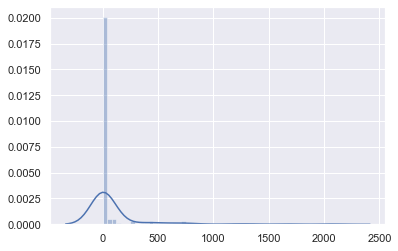

In [35]:
sns.set(color_codes=True)   
sns.distplot(false_Pos_all);
print("false_Pos = ", statistics.mean(false_Pos_all)*100/65536)

false_neg =  3.99932861328125


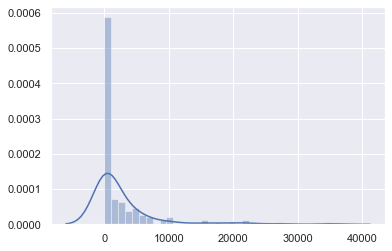

In [36]:
sns.set(color_codes=True)   
sns.distplot(false_neg_all);
print("false_neg = ", statistics.mean(false_neg_all)*100/65536)

# Data Stat 

In [ ]:
img = Image.open(f'green1_0/green292_100000.tif')
img = np.array(img)

In [ ]:
#img = img/np.max(img)
print('Max =',np.max(img),' Min =',np.min(img),' Mean =',np.mean(img))

Max = 2313.0098  Min = -12192.999  Mean = -5005.3853


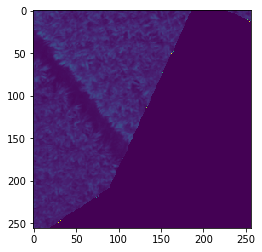

In [ ]:
plt.imshow(img)

([array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 256.,   0.]),
  array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 256.,   0.]),
  array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 256.,   0.]),
  array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 256.,   0.]),
  array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 256.,   0.]),
  array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 256.,   0.]),
  array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 256.,   0.]),
  array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 256.,   0.]),
  array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 256.,   0.]),
  array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 256.,   0.]),
  array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 256.,   0.]),
  array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 256.,   0.]),
  array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 256.,   0.]),
  array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 256.,   0.]),
  arra

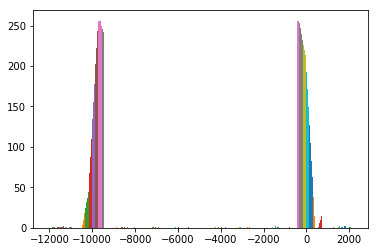

In [ ]:
plt.hist(img)

In [ ]:
img[img<0] =0
img[img>1] =0

In [ ]:
print('Max =',np.max(img),' Min =',np.min(img),' Mean =',np.mean(img))

Max = 0.89693296  Min = 0.0  Mean = 0.041029964


([array([153., 103.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([156., 100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([157.,  97.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([153.,  99.,   4.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([155.,  98.,   3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([156.,  97.,   3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([168.,  84.,   4.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([167.,  85.,   4.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([166.,  88.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([169.,  82.,   5.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([162.,  91.,   3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([166.,  88.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([162.,  92.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([164.,  90.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  arra

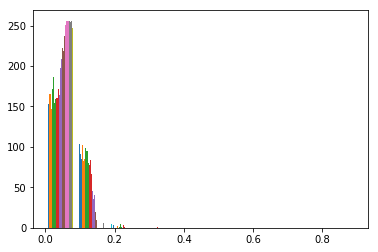

In [ ]:
plt.hist(img)#, bins='auto')

In [ ]:
img[img>0.5] =0
print('Max =',np.max(img),' Min =',np.min(img),' Mean =',np.mean(img))

Max = 0.4851954  Min = 0.0  Mean = 0.040927533


([array([ 33., 151.,  69.,   3.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([ 33., 152.,  69.,   2.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([ 33., 148.,  68.,   6.,   1.,   0.,   0.,   0.,   0.,   0.]),
  array([ 29., 151.,  66.,   8.,   2.,   0.,   0.,   0.,   0.,   0.]),
  array([ 26., 153.,  64.,  11.,   2.,   0.,   0.,   0.,   0.,   0.]),
  array([ 28., 166.,  48.,  13.,   1.,   0.,   0.,   0.,   0.,   0.]),
  array([ 32., 159.,  53.,  10.,   2.,   0.,   0.,   0.,   0.,   0.]),
  array([ 31., 159.,  55.,   9.,   2.,   0.,   0.,   0.,   0.,   0.]),
  array([ 33., 155.,  56.,  10.,   2.,   0.,   0.,   0.,   0.,   0.]),
  array([ 35., 155.,  55.,   9.,   2.,   0.,   0.,   0.,   0.,   0.]),
  array([ 41., 147.,  59.,   7.,   2.,   0.,   0.,   0.,   0.,   0.]),
  array([ 41., 148.,  61.,   5.,   1.,   0.,   0.,   0.,   0.,   0.]),
  array([ 42., 143.,  66.,   4.,   1.,   0.,   0.,   0.,   0.,   0.]),
  array([ 40., 147.,  61.,   7.,   1.,   0.,   0.,   0.,   0.,   0.]),
  arra

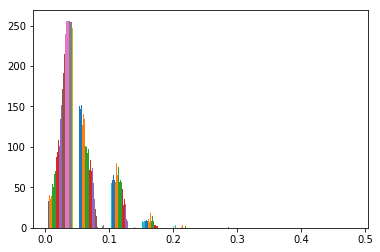

In [ ]:
plt.hist(img)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater_equal
  after removing the cwd from sys.path.


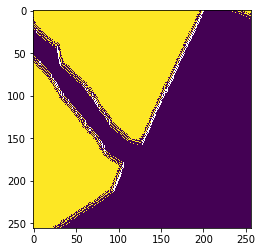

In [ ]:
mask = Image.open(f'mask/msk489_100000.tif')
mask = np.array(mask)
mask[mask <1] = 0
mask[mask >= 1] =1
plt.imshow(mask)